- 실제 신경망에서는 매개변수가 수천에서 수만, 나아가 층을 깊게 한 딥러닝 정도 되면 그 수는 수억에 이를 수 있다. 따라서 매개변수를 수작업으로 정한다는 것은 아예불가능하다. 이번 장에서는 신경망 학습(데이터로부터 매개변수의 값을 정하는 방법)에 대해서 설명하고 파이썬으로 MNIST 데이터셋의 손글씨 숫자를 학습하는 코드를 구현해본다.

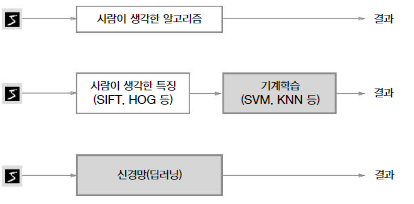  
- 딥러닝을 종단간 기계학습 end-to-end machine learning이라고도 합니다. 여기서 종단간은 '처음부터 끝까지'라는 의미로, 데이터(입력)에서 목표한 결과(출력)을 사람의 개입 없이 얻는다는 뜻을 담고 있다.

- 과적합, 오버피팅 : 한쪽 이야기(특정 데이터셋)만 너무 많이 들어서 편견이 생겨버린 상태라고 이해하자

In [1]:
y=[0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]
t=[0,0,1,0,0,0,0,0,0,0]

이처럼 한 원소만 1로하고 그 외는 0으로 나타내는 표기법을 원-핫 인코딩이라 한다.

In [4]:
import numpy as np

In [5]:
def sum_squares_error(y,t):
    return 0.5*np.sum((y-t)**2)

In [6]:
t=[0,0,1,0,0,0,0,0,0,0]
y=[0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]
sum_squares_error(np.array(y),np.array(t))

0.09750000000000003

In [7]:
y=[0.1,0.05,0.1,0.0,0.05,0.1,0.0,0.6,0.0,0.0]
sum_squares_error(np.array(y),np.array(t))

0.5975

In [8]:
def cross_entropy_error(y,t):
    delta=1e-7
    return -np.sum(t*np.log(y+delta))

- np.log를 계산할 때 아주 작은 값인 delta를 더했다. 이는 np.log()함수에 0을 입력하면 마이너스 무한대를 뜻하는 -inf가 되어 더 이상 계산을 진행할 수 없기 때문이다. 아주 작은 값을 더해서 절대 0이 되지 않도록, 즉 마이너스 무한대가 발생하지 않도록 한 것이다. 이 cross_entropy_error(y,t) 함수를 써본다.

In [10]:
t=[0,0,1,0,0,0,0,0,0,0]
y=[0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]
cross_entropy_error(np.array(y),np.array(t))

0.510825457099338

In [12]:
y=[0.1,0.05,0.1,0.0,0.05,0.1,0.0,0.6,0.0,0.0]
cross_entropy_error(np.array(y),np.array(t))

2.302584092994546

첫번째 예는 정답일 때의 출력이 0.6인 경우로, 이때의 교차 엔트로피 오차는 약 0.51입니다. 그다음은 정답일 떄의 출력이 더 낮은 0.1인 경우로, 이때의 교차 엔트로피 오차는 무려 2.3입니다. 즉, 결과(오차 값)가 더 작은 첫 번째 추정이 정답일 가능성이 높다고 판단한 것으로, 앞서 오차제곱합의 판단과 일치합니다.

# 미니배치 학습
- 기계학습 문제는 훈련 데이터를 사용해 학습한다. 더 구체적으로 말하면 훈련 데이터에 대한 손실 함수의 값을 구하고, 그 값을 최대한 줄여주는 매개변수를 찾아낸다. 이렇게 하려면 모든 훈련 데이터를 대상으로 손실 함수 값을 구해야 한다. 즉, 훈련 데이터가 100개 있으면 그로부터 계산한 100개의 손실 함수 값들의 합을 지표로 삼는다. 

In [16]:
import sys,os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True,one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


train 데이터에서 무작위로 10장만 빼내려면 넘파이의 np.random.choice() 함수를 쓰면 다음과 같이 간단히 해결할 수 있다.  
np.random.choice()로는 지정한 범위의 수 중에서 무작위로 원하는 개수만 꺼낼 수 있다. 가령 np.random.choice(60000,10)은 0이상 60000미만의 수 중에서 무작위로 10개를 골라낸다. 

In [19]:
train_size=x_train.shape[0]
batch_size=10
batch_mask=np.random.choice(train_size,batch_size)
x_batch=x_train[batch_mask]
t_batch=t_train[batch_mask]

In [20]:
np.random.choice(60000,10)

array([13129, 43607, 59081, 22818, 57585, 24643, 58146, 59633, 45439,
        8325])

이제 무작위로 선택한 이 인덱스를 사용해 미니배치를 뽑아내기만 하면 된다. 손실 함수도 이 미니배치로 계산한다. 

텔레비전 시청률도 모든 세대의 텔레비전이 아니라 선택된 일부 가구의 텔레비전만을 대상으로 구성한다. 예를 들어 경기 지방에서 무작위로 선정한 1,000가구를 대상으로 시청률을 계측한 다음, 경기 지방 전체의 시청률로 근사하는 것이다. 그 1,000가구의 시청률이 전체 시청률과 정확히 일치하지는 않겠지만, 전체 대략적인 값으로 사용할 수 있다. 이 시청률 이야기와 마찬가지로 미니배치의 손실 함수도 일부 표본 데이터로 전체를 비슷하게 계측한다.즉, 전체 훈련 데이터의 대표로서 무작위로 선택한 작은 덩어리(미니배치)를 사용하는 것이다. 

# 배치용 교차 엔트로피 오차 구하기
- 데이터가 하나인 경우와 데이터가 배치로 묶여 입력될 경우 모두 처리하게 한다.

In [21]:
def cross_entropy_error(y,t):
    if y.ndim==1:
        t=t.reshape(1,t.size)
        y=y.reshape(1,y.size)
    batch_size=y.shape[0]
    return -np.sum(t*np.log(y+1e-7))/batch_size

In [22]:
def cross_entropy_error(y,t):
    if y.ndim==1:
        t=t.reshape(1,t.size)
        y=y.reshape(1,y.size)
    batch_size=y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size),t]+1e-7))/batch_size

신경망을 학습할 때 정확도를 지표로 삼아서는 안 된다. 정확도를 지표로 하면 매개변수의 미분이 대부분의 장소에서 0이 되기 때문이다. 

In [23]:
#나쁜 구현 예
def numerical_diff(f,x):
    h=10e-50
    return (f(x+h)-f(x))/h

In [24]:
def numerical_diff(f,x):
    h=1e-4
    return (f(x+h)-f(x-h))/(2*h)

여기에서 하는 것처럼 아주 작은 차분으로 미분하는 것을 수치 미분이라 합니다. 한편, 수식을 전개해 미분하는 것은 해석적이라는 말을 이용하여 '해석적 해' 혹은 '해석적으로 미분하다'등으로 표현합니다. 가령 y=x^2의 미분은 해석적으로는 dy/dx=2x로 풀어낼 수 있습니다. 그래서 x=2일 때 y의 미분은 4가 됩니다. 해석적 미분은 오차를 포함하지 않는 '진정한 미분'값을 구해줍니다.  
- 해석적 이분은 우리가 수학 시간에 배운 바로 그 미분이고, '수치 미분'은 이를 '근사치'로 계산하는 방법이다. 즉, 수치해석학은 "해석학 문제에서 수치적인 근삿값을 구하는 알고리즘을 연구하는 학문"이다.

In [25]:
def function_1(x):
    return 0.01*x**2+0.1*x

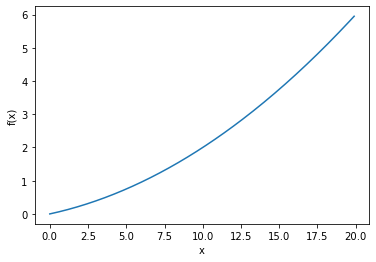

In [26]:
import numpy as np
import matplotlib.pylab as plt

x=np.arange(0.0,20.0,0.1)
y=function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x,y)
plt.show()

In [27]:
numerical_diff(function_1,5) # x가 5일때 미분

0.1999999999990898

In [28]:
numerical_diff(function_1,10) #x가 10일때 미분

0.2999999999986347

0.1999999999990898


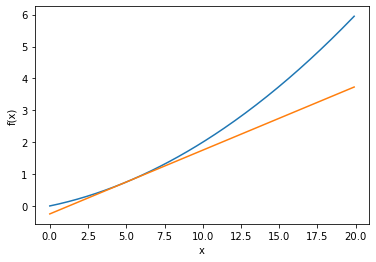

In [1]:
# coding: utf-8
import numpy as np
import matplotlib.pylab as plt


def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)


def function_1(x):
    return 0.01*x**2 + 0.1*x 


def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()


# 기울기

No handles with labels found to put in legend.


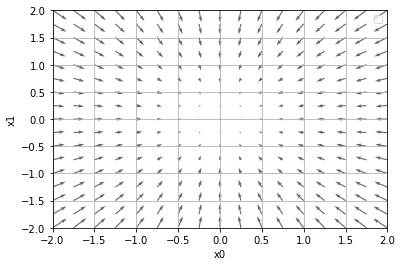

In [4]:
# coding: utf-8
# cf.http://d.hatena.ne.jp/white_wheels/20100327/p3
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D


def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()
    
    grad = numerical_gradient(function_2, np.array([X, Y]) )
    
    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.legend()
    plt.draw()
    plt.show()


In [5]:
numerical_gradient(function_2,np.array([3.0,4.0]))

array([6., 8.])

In [6]:
numerical_gradient(function_2,np.array([0.0,2.0]))

array([0., 4.])

In [7]:
numerical_gradient(function_2,np.array([3.0,0.0]))

array([6., 0.])

- 실제로는 [6.00000000000000037081, 7.9999999999999999991189]라는 값이 얻어지지만 [6.,8.]으로 출력됩니다. 이는 넘파이 배열을 출력할 때 수치를 '보기 쉽도록'가공하기 때문입니다.
- 이 그림을 보면 기울기는 함수의 '가장 낮은 장소(최솟값)'를 가리키는 것 같습니다. 마치 나침반처럼 화살표들은 한 점을 향하고 있지요. 또 '가장 낮은 곳'에서 멀어질수록 화살표의 크기가 커짐을 알 수 있습니다.
- 기울기는 가장 낮은 장소를 가리킵니다만, 실제는 반드시 그렇다고 할 수 없습니다. 사실 기울기는 각 지점에서 낮아지는 방향을 가리킵니다. 더 정확히 말하자면 **기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향**입니다.

# 경사법(경사 하강법)
- 기계학습 문제 대부분은 학습 단계에서 최적의 매개변수를 찾아냅니다. 신경망 역시 최적의 매개변수 (가중치와 편향)를 학습 시에 찾아야 합니다. 여기에서 최적이란 손실 함수가 최솟값이 될 때의 매개변수 값입니다. 그러나 일반적인 문제의 손실 함수는 매우 복잡하죠. 매개변수 공간이 광대하여 어디가 최솟값이 되는 곳인지를 짐작할 수 없습니다. 이런 상황에서 기울기를 잘 이용해 함수의 최솟값 (또는 가장 가능한 한 작은 값)을 찾으려는 것이 경사법입니다. 

- 여기에서 주의할 점은 각 지점에서 함수의 값을 낮추는 방안을 제시하는 지표가 기울기라는 것입니다. 그러나 기울기가 가리키는 곳에 정말 함수의 최솟값이 있는지, 즉 그쪽이 정말로 나아갈 방향인지는 보장할 수 없습니다. 실제로 복잡한 함수에서는 기울기가 가리키는 방향에 최솟값이 없는 경우가 대부분입니다.

- 함수가 극솟값, 최솟값, 또는 안장점 saddle point 가 되는 장소에서는 기울기가 0입니다. 극솟값은 국소적인 최솟값, 즉 한정된 범위에서의 최솟값인 점입니다. 안장점은 어느 방향에서 보면 극댓값이고 다른 방향에서 보면 극솟값이 되는 점입니다. 경사법은 기울기가 0인 장소를 찾지만 그것이 반드시 최솟값이라고는 할 수 없습니다. (극솟값이나 안장점일 가능성이 있습니다). 또, 복잡하고 찌그러진 모양의 함수라면 (대부분) 평평한 곳으로 파고들면서 고원(plateau 플래토)이라 하는, 학습이 진행되지 않는 정체기에 빠질 수 있습니다.

- 기울어진 방향이 꼭 최솟값을 가리키는 것은 아니나, 그 방향으로 가야 함수의 값을 줄일 수 있습니다. 그래서 최솟값이 되는 장소를 찾는 문제(아니면 가능한 한 작은 값이 되는 장소를 찾는 문제)에서는 기울기 정보를 단서로 나아갈 방향을 정해야 합니다. 

- 드이어 경사법이 등장할 차례입니다. **경사법은 현 위치에서 기울어진 방향으로 일정 거리만큼 이동**합니다. 그런 다음 이동한 곳에서도 마찬가지로 기울기를 구하고, 또 그 기울어진 방향으로 나아가기를 반복합니다. 이렇게 해서 함수의 값을 점차 줄이는 것이 경사법 gradient method입니다. 경사법은 기계학습을 최적화하는 데 흔히 쓰는 방법입니다. 특히 신경망 학습에는 경사법을 많이 사용합니다.

- 경사법은 최솟값을 찾느냐, 최댓값을 찾느냐에 따라 이름이 다릅니다. 전자를 **경사 하강법 gradient method**이라고 하죠. 다만 손실 함수의 부호를 반전시키면 최솟값을 찾는 문제와 최댓값을 찾는 문제는 같은 것이니 하강이냐 상승이냐는 본질적으로는 중요하지 않습니다. 일반적으로는 신경망(딥러닝) 분야에서의 경사법은 '경사 하강법'으로 등장할 때가 많습니다.

In [8]:
def gradient_descent(f,init_x,lr=0.01,step_num=100):
    x=init_x
    for i in range(step_num):
        grad=numerical_gradient(f,x)
        x-=lr*grad
    return x

- 인수 f는 최적화하려는 함수, init_x는 초깃값, lr은 learning rate를 의미하는 학습률, step_num은 경사법에 따른 반복횟수를 뜻합니다. 함수의 기울기는 numerical_gradient(f,x)로 구하고, 그 기울기에 학습률을 곱한 값으로 갱신하는 처리를 step_num번 반벅합니다. 

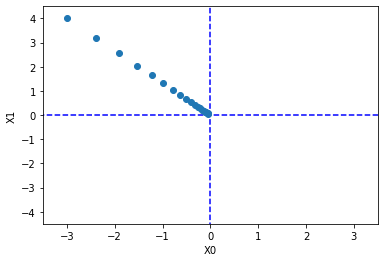

In [9]:
# coding: utf-8
import numpy as np
import matplotlib.pylab as plt
from gradient_2d import numerical_gradient


def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()


- 학습률이 너무 큰 예 : lr=10.0

In [10]:
init_x=np.array([-3.0,4.0])
gradient_descent(function_2,init_x=init_x,lr=10.0,step_num=100)

(array([-2.58983747e+13, -1.29524862e+12]),
 array([[-3.00000000e+00,  4.00000000e+00],
        [ 5.70000000e+01, -7.60000000e+01],
        [-1.08300000e+03,  1.44400000e+03],
        [ 2.05770000e+04, -2.74360000e+04],
        [-3.90963008e+05,  5.21284002e+05],
        [ 7.42829664e+06, -9.90439654e+06],
        [-1.41137328e+08,  1.88183103e+08],
        [ 2.68126267e+09, -3.57501690e+09],
        [-5.09763373e+10,  6.79001831e+10],
        [ 9.45170863e+11, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.29524862e+12],
        [-2.58983747e+13, -1.295

- 학습률이 너무 작은 예 : lr=1e-10

In [11]:
init_x=np.array([-3.0,4.0])
gradient_descent(function_2,init_x=init_x,lr=1e-10,step_num=100)

(array([-2.99999994,  3.99999992]),
 array([[-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  3.99999999],
        [-3.        ,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999999],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999999,  3.99999998],
        [-2.99999998,  3.99999998],
        [-2.99999998,  3.999

- 학습률이 너무 크면 큰 값으로 발산해버립니다. 반대로 너무 작으면 거의 갱신되지 않은 채 끝나머리네요. 따라서 학습률을 적절히 설정하는것은 매우 중요합니다.

- 학습률 같은 매개변수를 하이퍼파라미터 라고 합니다. 이는 가중치와 편향 같은 신경망의 매개변수와는 성질이 다른 매개변수입니다. 신경망의 **가중치 매개변수는 훈련 데이터와 학습 알고리즘에 의해서 '자동'으로 획득되는 매개변수**인 반면, **학습률 같은 하이퍼파라미터는 사람이 직접 설정해야 하는 매개변수**인 것이죠. 일반적으로는 이 하이퍼파라미터들은 여러 후보 값 중에서 시험을 통해 가장 잘 학습하는 값을 찾는 과정을 거쳐야 합니다.

In [12]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient


class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

print(dW)


[[ 0.12359633  0.22367564 -0.34727197]
 [ 0.1853945   0.33551346 -0.52090795]]


In [13]:
x=np.array([0.5,0.9])
p=net.predict(x)
print(p)

[-0.10356416  0.5762945   0.66170789]


In [14]:
np.argmax(p)

2

In [15]:
t=np.array([0,0,1])
net.loss(x,t)

0.8685026344854629

In [16]:
f=lambda w: net.loss(x,t)

In [17]:
dW=numerical_gradient(f,net.W)

여기에서 사용한 numerical_gradient()는 가중치 매개변수 W가 다차원 배열을 처리할 수 있도록 앞의 구현에서 조금 수정했습니다. 

## 전제
- 신경망에서는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라 합니다. 신경망 학습은 다음과 같이 4단계로 수행합니다.
## 1단계 - 미니배치
- 훈련 데이터 중 일부를 무작위로 가져옵니다. 이렇게 선별한 데이터를 미니배치라 하며, 그 미니배치의 손실 함수 값을 줄이는 것이 목표입니다.
## 2단계 - 기울기 산출
- 미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구합니다. **기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시**합니다
## 3단계 - 매개변수 갱신
- **가중치 매개변수를 기울기 방향으로 아주 조금 갱신**합니다.
## 4단계 - 반복
- 1~3단계를 반복합니다.

- 이는 경사 하강법으로 매개변수를 갱신하는 방법이며, 이때 데이터를 미니배치로 무작위로 선정하기 때문에 확률적 경사 하강법 stochastic gradient descent, SGD이라고 부릅니다. '확률적으로 무작위로 골라낸 데이터'에 대해 수행하는 경사 하강법이라는 의미죠. 대부분의 딥러닝 프레임워크는 확률적 경사 하강법의 여엉 머리글자를 딴 SGD라는 함수로 이 기능을 구현하고 있습니다. 

In [18]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads


In [19]:
net=TwoLayerNet(input_size=784,hidden_size=100,output_size=10)
net.params['W1'].shape
net.params['b1'].shape
net.params['W2'].shape
net.params['b2'].shape

(10,)

In [20]:
x=np.random.rand(100,784)
y=net.predict(x)

In [32]:
x=np.random.rand(100,784) # 더미 입력 레이블(100장 분량)
t=np.random.rand(100,10) #더비 정답 레이블(100장분량)

grads=net.numerical_gradient(x,t) #기울기 계산

grads['W1'].shape 
grads['b1'].shape
grads['W2'].shape
grads['b2'].shape 

KeyboardInterrupt: 

- numerical_gradient(self,x,t)는 수치 미분 방식으로 매개변수의 기울기를 계산합니다. 다음 장에서는 이 기울기 계산을 고속으로 수행하는 기법을 설명합니다. 그 방법은 바로 오차역전파법입니다. 오차역전파법을 쓰면 수치 미분을 사용할 때와 거의 같은 결과를 훨씬 빠르게 얻을 수 있죠. 오차역전파법으로 기울기를 구하는 gradient(self,x,t) 메서드는 다음 장에서 구현합니다. 신경망 학습은 시간이 오래 걸리니, 시간을 절약하려면 numerical_gradient(self,x,t) 대신 gradient(self,x,t)를 쓰는 것이 좋습니다.!

train acc, test acc | 0.10218333333333333, 0.101
train acc, test acc | 0.7965, 0.8024
train acc, test acc | 0.8760166666666667, 0.8803
train acc, test acc | 0.89695, 0.9008
train acc, test acc | 0.9067833333333334, 0.9096
train acc, test acc | 0.9134, 0.9173
train acc, test acc | 0.9182666666666667, 0.9194
train acc, test acc | 0.9225166666666667, 0.9243
train acc, test acc | 0.92675, 0.9276
train acc, test acc | 0.9289333333333334, 0.9303
train acc, test acc | 0.9320166666666667, 0.9329
train acc, test acc | 0.9351666666666667, 0.9354
train acc, test acc | 0.93745, 0.9377
train acc, test acc | 0.9404166666666667, 0.9398
train acc, test acc | 0.9417166666666666, 0.9416
train acc, test acc | 0.94435, 0.9422
train acc, test acc | 0.9464, 0.9446


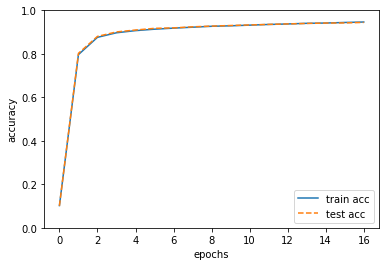

In [33]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


- 여기에서는 미니 배치 크기를 100으로 했습니다. 즉, 매번 60,000개의 훈련 데이터에서 임의로 100개의 데이터(이미지 데이터와 정답 레이블 데이터)를 추려냅니다. 그리고 그 100개의 미니배치를 대상으로 확률적 경사 하강법을 수행해 매개변수를 갱신합니다. 경사법에 의한 갱신 횟수(반복 횟수)를 10,000번으로 설정하고, 갱신할 때마다 훈련 데이터에 대한 손실 함수를 계산하고, 그 값을 배열에 추가합니다.

- 에폭 epoch은 하나의 단위입니다. 1에폭은 학습에서 훈련 데이터를 모두 소진했을 때의 횟수에 해당합니다. 예컨대 **훈련 데이터 10,000개를 100개의 미니배치로 학습할 경우, 확률적 경사하강법을 100회 반복하면 모든 훈련 데이터를 '소진'** 한 게 됩니다. 이 경우 100회가 1에폭이 됩니다. 

* 만약 오버피팅이 일어난다면 이 모습은 어떻게 달라질까요? 훈련이란 훈련 데이터에 대한 정확도를 높이는 방향으로 학습하는 것이니 그 정확도는 에폭을 반복할 수록 높아집니다. 반면 훈련 데이터에 지나치게 적응하면, 즉 오버피팅되면 훈련 데이터와는 다른 데이터를 보면 잘못된 판단을 하기 시작합니다. 어느 순간부터 시험 데이터에 대한 정확도가 점차 떨어지기 시작한다는 뜻입니다. 이 순간이 오버피팅이 시작되는 순간입니다. 여기서 중요한 인사이트! 이 순간을 포착해 학습을 중단하면 오버피팅을 효과적으로 예방할 수 있겠죠? 이 기법을 조기 종료 early stopping라하며 가중치 감소, 드롭아웃과 함께 대표적인 오버피팅 예방법입니다.

- 수치 미분을 이용한 계산에는 시간이 걸리지만, 그 구현은 간단하다. 한편, 다음 장에서는 구현하는 (다소 복잡한) 오차역전파법은 기울기를 고속으로 구할 수 있다.

[수치미분](https://chacha95.github.io/2018-11-01-numerical/#:~:text=%EC%B0%BE%EB%8A%94%20%EB%B0%A9%EC%8B%9D%EC%9E%85%EB%8B%88%EB%8B%A4.-,%EC%88%98%EC%B9%98%20%EB%AF%B8%EB%B6%84(numerical%20differentiation),%EB%A5%BC%20%EB%82%BC%20%EC%88%98%20%EC%9E%88%EA%B2%8C%20%ED%95%B4%EC%A4%8D%EB%8B%88%EB%8B%A4.)